### Configuración

Primero se cargan las librerías necesarias para el desarrollo del _notebook_

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yaml import safe_load
from scipy.stats import bernoulli, norm
from matplotlib.ticker import ScalarFormatter

Ahora se definen rutas relativas al _notebook_, para una adecuada manipulación de archivos dentro del directorio raíz.

In [2]:
# Ruta a directorio raíz
ROOT = os.path.dirname(os.getcwd())

# Abrir archivo de configuración
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as _file:
    CONFIG = safe_load(_file)
_file.close()

# 1. Espacio parametral

Ejemplo de lanzamientos de una moneda, primero se construye un dataframe con lanzamientos independientes de una moneda justa

In [3]:
n = 1_000

moneda = (
    # Generar dataframe con n realizaciones bernoulli
    pd.DataFrame(
        data={
            'lanzamiento': np.arange(1, n+1, 1)
            # 0: Águila, 1: Sol
            ,'moneda': bernoulli.rvs(p=0.5, loc=0, size=n, random_state=123)
            }
        )
    # Asignar columnas computadas
    .assign(
        # Acumulado de Sol
        acumulado = lambda _df: _df.moneda.cumsum()
        # Probabilidad acumulada de Sol
        ,prob = lambda _df: _df.acumulado / _df.lanzamiento
    )
)

moneda.head()

,lanzamiento,moneda,acumulado,prob
0,1,1,1,1.000000
1,2,0,1,0.500000
2,3,0,1,0.333333
3,4,1,2,0.500000
4,5,1,3,0.600000


Ahora se visualiza la probabilidad a lo largo de las realizaciones realizadas

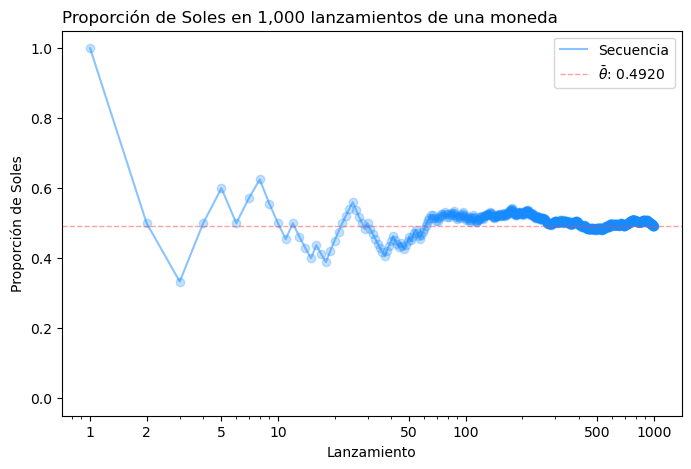

In [4]:
# Configuración de figura
fig, ax = plt.subplots(figsize=(8,5))

# Estilo de los ejes
ax.set_xscale('log')
ax.set_xticks(ticks=np.array([1,2,5,10,50,100,500,1000]))
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.set_ylim(bottom=-0.05, top=1.05)

# Elementos de visualización
ax.plot(
    moneda.lanzamiento
    ,moneda.prob
    ,c=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5
    ,label='Secuencia')
ax.scatter(
    x=moneda.lanzamiento
    ,y=moneda.prob
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.25)
ax.axhline(
    y=moneda.loc[n-1, 'prob']
    ,linestyle='--'
    ,linewidth=1
    ,color=CONFIG['graficas']['colors']['rojo']
    ,alpha=0.5
    ,label=rf"$\bar\theta$: {moneda.loc[n-1, 'prob']:.4f}"
)

# Anotaciones de figura
ax.set_title(f'Proporción de Soles en {n:,} lanzamientos de una moneda', loc='left')
ax.set_xlabel('Lanzamiento')
ax.set_ylabel('Proporción de Soles')
ax.legend()

plt.show()

Esto cambia cuando el espacio parametral es continuo, por ejemplo, qué pasa si ahora se analiza la estatura de un grupo de personas escogidas aleatoriamente.

In [5]:
n = 10_000
bins = 20

estaturas = (
    pd.DataFrame(
        data={
            'persona': np.arange(start=1, stop=n+1, step=1)
            ,'estatura': norm.rvs(loc=165, scale=5, size=n, random_state=123)
        }
    )
    .assign(
        intervalo = lambda _df: pd.cut(x=_df.estatura, bins=bins)
    )
)

estaturas.head()

,persona,estatura,intervalo
0,1,159.571847,"(157.797, 159.765]"
1,2,169.986727,"(169.602, 171.569]"
2,3,166.414892,"(165.667, 167.634]"
3,4,157.468526,"(155.83, 157.797]"
4,5,162.106999,"(161.732, 163.699]"


Ahora se pueden visualizar los intervalos de estatura a los que pertenece cada persona

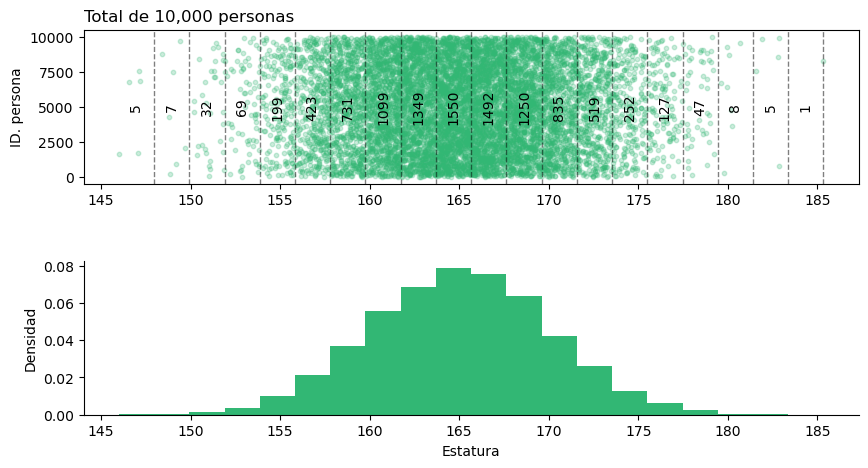

In [6]:
# Datos de la visualización
_counts = estaturas.intervalo.cat.codes.value_counts()

# Configuración de figura
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(nrows=2, ncols=1, figure=fig, hspace=0.5)

# Elementos de visualización
ax1 = fig.add_subplot(gs[0])
ax1.scatter(
    x=estaturas.estatura
    ,y=estaturas.persona
    ,s=10
    ,color=CONFIG['graficas']['colors']['verde']
    ,alpha=0.25
)
for _code, _interv in enumerate(estaturas.intervalo.cat.categories):
    ax1.axvline(
        x=_interv.right
        ,linestyle='--'
        ,linewidth=1
        ,color='black',
        alpha=0.5)
    ax1.text(
        x=_interv.mid
        ,y=n/2
        ,s=_counts[_code]
        ,rotation='vertical'
        ,verticalalignment='center'
        ,horizontalalignment='center')
    
# Elementos de visualización
ax2 = fig.add_subplot(gs[1])
ax2.hist(
    x=estaturas.estatura
    ,bins=bins
    ,density=True
    ,color=CONFIG['graficas']['colors']['verde'])

# Anotaciones de figura
ax1.set_title(f'Total de {n:,} personas', loc='left')
ax1.set_ylabel('ID. persona')

ax2.set_xlabel('Estatura')
ax2.set_ylabel('Densidad')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plt.show()

En datos continuos, es necesario obtener las densidades de los intervalos a los que pertenece cada individuo de la población para interpretar probabilidades. Esto se puede hacer a través de un histograma utilizando los conteos de cada uno.

* La **masa** está definida por el número total de individuos en ese intervalo, entre el total de individuos.
* La **densidad** se define por la masa del intervalo entre la longitud del mismo.

Es muy importante tener claro que la densidad de probabilidad puede tomar valores mayores a 1, aunque la masa de probabilidad en conjunto sume 1. Esto pasa principalmente cuando se tienen distribuciones muy estrechas, en donde en un rango muy pequeño se concentra una gran cantidad de masa.

# 2. Intervalos de confianza

Supongamos que se tienen las siguientes mediciones del mismo fenómeno: $y_i\in[35,34,38,35,37]$, entonces se pueden obtener algunos resúmenes al respecto de los datos, por ejemplo:

**Media**

In [7]:
y = np.array([35,34,38,35,37])
n = len(y)

estimador = y.mean()
estimador

35.8

**Error estándar**

In [8]:
std_err = y.std() / np.sqrt(n)
std_err

0.6572670690061992

**Intervalos de confianza**

En datos continuos se puede calcular utilizando la distribución normal, por ejemplo:

In [9]:
print(f"Intervalo de confianza al 50%: {estimador + norm.ppf([0.25,0.75]) * std_err }")
print(f"Intervalo de confianza al 95%: {estimador + norm.ppf([0.025,0.975]) * std_err}")

Intervalo de confianza al 50%: [35.3566801 36.2433199]
Intervalo de confianza al 95%: [34.51178022 37.08821978]


Para proporciones, los intervalos de confianza se calculan directamente de los datos. por ejemplo, suponiendo que en una encuesta 700 personas respondieron SI, mientras que 300 respondieron NO, entonces:

In [10]:
y = 700
n = 1_000

estimador = y / n
std_err = np.sqrt(estimador * (1 - estimador) / n)

print(f"Intervalo de confianza al 95%: {estimador + norm.ppf([0.025,0.975]) * std_err}")

Intervalo de confianza al 95%: [0.67159742 0.72840258]


Para datos que tienen un mayor nivel de complejidad, se puede obtener el intervalo de confianza utilizando simulación. Para ilustrarlo, supongamos que se tiene una encuesta de 1,100 personas de las cuales, 700 están a favor de una postura, 300 se oponen, y 100 no respondieron.

Un estimado de la proporción de la población que está a favor es 0.7 con un intervalo de [0.67,0.73] para una confianza del 95%, como en el ejercicio anterior.

Ahora supón que de las 1,000 personas que contestaron 500 fueron hombres y 500 mujeres, y supón que dentro de cada grupo el 75% de hombres y el 65% de mujeres está a favor de la postura. La tasa de hombres a favor contra mujeres a favor sería 0.75/0.65 = 1.15, es decir, 15% más hombres están a favor con respecto a las mujeres, sin embargo, el error estándar no es tan fácil de obtener en este caso. 

El enfoque más directo para obtenerlo es utilizando simulación:

In [11]:
# Error estándar en hombres
n_hombres = 500
p_hat_hombres = 0.75
std_err_hombres = np.sqrt(p_hat_hombres * (1 - p_hat_hombres) / n_hombres)

# Error estándar en mujeres
n_mujeres = 500
p_hat_mujeres = 0.65
std_err_mujeres = np.sqrt(p_hat_mujeres * (1 - p_hat_mujeres) / n_mujeres)

In [12]:
n_sims = 10_000

p_hombres = norm.rvs(loc=p_hat_hombres, scale=std_err_hombres, size=n_sims)
p_mujeres = norm.rvs(loc=p_hat_mujeres, scale=std_err_mujeres, size=n_sims)

tasa = p_hombres / p_mujeres

int_95 = pd.Series(tasa).quantile([0.025,0.975])
int_95

0.025    1.064252
0.975    1.250570
dtype: float64